# Latest Reproduce
- Using provided original trials
- Image: resized and with white background (detailed in `datasets/resize_object.py`)
- Tokenizer: without `<eos> <sos>` tokens

We only use 1 seed(seed=0) in this hole reproduce, because currently only 1 model checkpoint is available.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import utils
import matplotlib.ticker as mtick
from scipy.stats import kendalltau

In [2]:
# grep clip&cvcl results
files = glob.glob('results/reported_trial_repro/*.json')
df, overall_acc = utils.parse_results(files)
print(df.head(10))
print(overall_acc)

     Category  Accuracy  Seed  Mean_Accuracy
1       apple  0.920000     0       0.920000
26       crib  0.906667     0       0.906667
34      juice  0.773333     0       0.773333
20        cat  0.733333     0       0.733333
16  butterfly  0.720000     0       0.720000
58       tree  0.693333     0       0.693333
32        hat  0.626667     0       0.626667
14      broom  0.626667     0       0.626667
28        dog  0.600000     0       0.600000
8        bell  0.573333     0       0.573333
{'clip': 0.9947534102833159, 'cvcl_res': 0.35424973767051415}


In [3]:
# function to draw fig.3A
def plt_class_acc(df_class, overall_acc, split_index):
    categories = df_class['Category'].unique()
            
    dfs = [df_class[df_class['Category'].isin(categories[:split_index])], 
           df_class[df_class['Category'].isin(categories[split_index:])]]

    cvcl_key = next((k for k in overall_acc if 'cvcl' in k), None)
    clip_key = next((k for k in overall_acc if 'clip' in k), None)

    fig, axs = plt.subplots(2, 1, figsize=(11, 7), sharey=True)
    # fig.suptitle('Repro Results Using Provided Trial File', fontsize=18)
    meanpointprops = dict(marker='o', markeredgecolor='gray', markerfacecolor='Black', markersize=2.5)

    for i, df_part in enumerate(dfs):
        sns.boxplot(x='Category', y='Accuracy', data=df_part, ax=axs[i], color='silver',
                    fliersize=0, linewidth=1.5, showmeans=True, meanprops=meanpointprops)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=35, ha='right', fontsize=11)
        axs[i].set_ylabel('Accuracy (%)', fontsize=15)
        axs[i].set_xlabel('')
        axs[i].axhline(y=0.25, color='black', linestyle='--', linewidth=2.0)
        axs[i].axhline(y=overall_acc[cvcl_key], color='green', linestyle='--', linewidth=2.0)
        axs[i].axhline(y=overall_acc[clip_key], color='cornflowerblue', linestyle='--', linewidth=2.0)
        
        axs[i].text(len(df_part['Category'].unique()) + 0.1, overall_acc[cvcl_key], f'CVCL {overall_acc[cvcl_key]*100:.2f}%',
                    color='green', va='center', fontsize=12)
        axs[i].text(len(df_part['Category'].unique()) + 0.1, overall_acc[clip_key], f'CLIP {overall_acc[clip_key]*100:.2f}%',
                    color='cornflowerblue', va='center', fontsize=12)
        axs[i].text(len(df_part['Category'].unique()) + 0.1, 0.25, f'Baseline 25.00%',
                    color='Black', va='center', fontsize=12)
        
        axs[i].grid(True, linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
        axs[i].set_ylim(0, 1.02)
        axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_146492/1711161209.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=35, ha='right', fontsize=11)
/tmp/ipykernel_146492/1711161209.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=35, ha='right', fontsize=11)


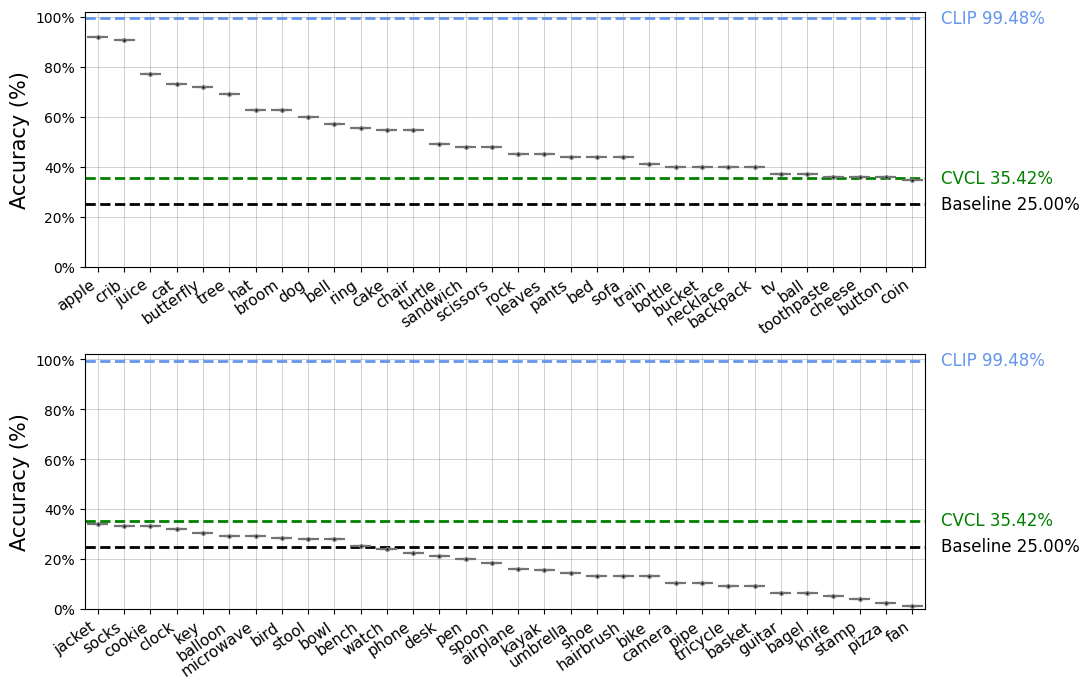

In [4]:
plt_class_acc(df, {k: np.mean(v) for k, v in overall_acc.items()}, len(df['Category'].unique()) // 2)

## Order Correlation Analysis
1. Using Kendall's tau to measure the correlation between the order of reproduced results
2. Visualize using a heatmap-like plot, showing difference of order

In [5]:
repro_order = df.sort_values(by='Mean_Accuracy', ascending=False)['Category'].unique().tolist()

with open('results/reported_order.txt', 'r') as file: # derived from original results
    reported_order = [line.strip() for line in file.readlines()]

print(repro_order[:6])
print(reported_order[:6])

['apple', 'crib', 'juice', 'cat', 'butterfly', 'tree']
['apple', 'crib', 'butterfly', 'juice', 'broom', 'hat']


In [6]:
# calculate Kendall's tau
def generate_rank_map(order_list):
    """Create a mapping from list items to their indices."""
    return {item: rank for rank, item in enumerate(order_list)}

def calculate_kendalls_tau(DIY_order, reported_order):
    """Calculate Kendall's tau between two orderings."""
    rank_map_DIY, rank_map_reported = generate_rank_map(DIY_order), generate_rank_map(reported_order)
    rank_DIY = [rank_map_DIY[item] for item in reported_order]
    # print(rank_DIY)
    rank_reported = [rank_map_reported[item] for item in reported_order]
    # print(rank_reported)

    tau, p_value_tau = kendalltau(rank_DIY, rank_reported)
    return tau, p_value_tau

rank_map_repro, rank_map_reported = generate_rank_map(repro_order), generate_rank_map(reported_order)
tau, p_value_tau = calculate_kendalls_tau(repro_order, reported_order)
print("Kendall's tau:", tau, "p-value:", p_value_tau)

Kendall's tau: 0.751984126984127 p-value: 1.5898550177435159e-18


Still not exactly the same, might because of the randomness of seed:
- `reported_order` here is published in paper, with all 3 seeds
- `reproduced_order` is only 1 seed

After filtering seed0 results in original result summary:

In [7]:
with open('results/reported_order_seed_0.txt', 'r') as file: # derived from original results
    reported_order_0 = [line.strip() for line in file.readlines()]

tau, p_value_tau = calculate_kendalls_tau(repro_order, reported_order_0)
print("Kendall's tau:", tau, "p-value:", p_value_tau)

Kendall's tau: 0.8898809523809524 p-value: 2.647125021726825e-25


We have much closer results this time, with only 1 seed!

## Visualize the order difference:
- Anchored on origianl(reported) order of object evaluation, x-axis is the original order
- The darker the blue, the more different order of this class
- E.g. “apple” is 1st in reported rank, but 38 ahead in our DIY reproduced rank(39th)

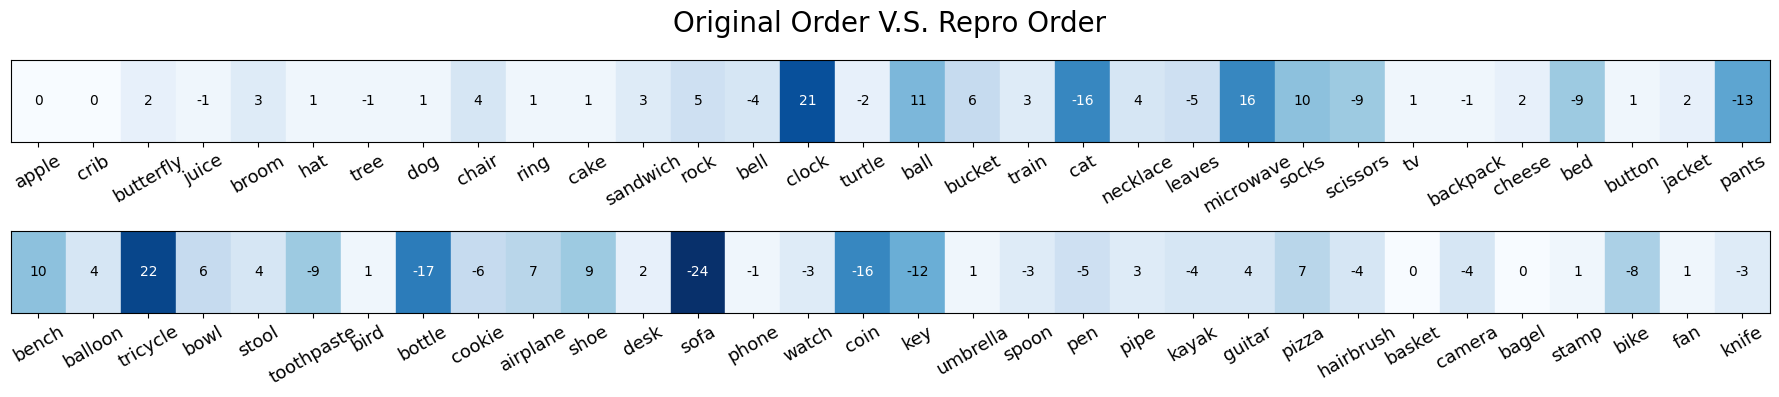

In [8]:
def plt_order_diff(rank_map_DIY, rank_map_reported):
# calculate the difference between the two orders
    differences = np.array([rank_map_DIY[item] - rank_map_reported[item] for item in reported_order])

    abs_diff = np.abs(differences)
    # seperate plot in 2 parts
    mid_point = len(reported_order) // 2

    # 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4))  
    fig.suptitle('Original Order V.S. Repro Order', fontsize=20)

    # color heatmap
    cmap = plt.get_cmap('Blues')
    norm = plt.Normalize(vmin=min(abs_diff), vmax=max(abs_diff))

    # first part
    for i, value in enumerate(abs_diff[:mid_point]):
        color = cmap(norm(value))
        square = plt.Rectangle((i, 0), 1, 1, color=color)
        ax1.add_patch(square)
        # display the actual difference value as text
        text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
        ax1.text(i + 0.5, 0.5, differences[i], ha='center', va='center', color=text_color, fontsize=10)

    ax1.set_xlim(0, mid_point)
    ax1.set_ylim(0, 1)
    ax1.set_xticks(np.arange(0.5, mid_point + 0.5, 1))
    ax1.set_xticklabels(reported_order[:mid_point], rotation=30, fontsize=13)
    ax1.set_yticks([])

    # second part
    for i, value in enumerate(abs_diff[mid_point:]):
        color = cmap(norm(value))
        square = plt.Rectangle((i, 0), 1, 1, color=color)
        ax2.add_patch(square)
        # display the actual difference value as text
        text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
        ax2.text(i + 0.5, 0.5, differences[mid_point + i], ha='center', va='center', color=text_color, fontsize=10)

    ax2.set_xlim(0, len(abs_diff) - mid_point)
    ax2.set_ylim(0, 1)
    ax2.set_xticks(np.arange(0.5, len(abs_diff) - mid_point + 0.5, 1))
    ax2.set_xticklabels(reported_order[mid_point:], rotation=30, fontsize=13)
    ax2.set_yticks([])

    plt.tight_layout()
    plt.show()

plt_order_diff(rank_map_repro, rank_map_reported)

Above is reproduced order comparing to original order(all seeds), below is comparing to original order(seed0 only)

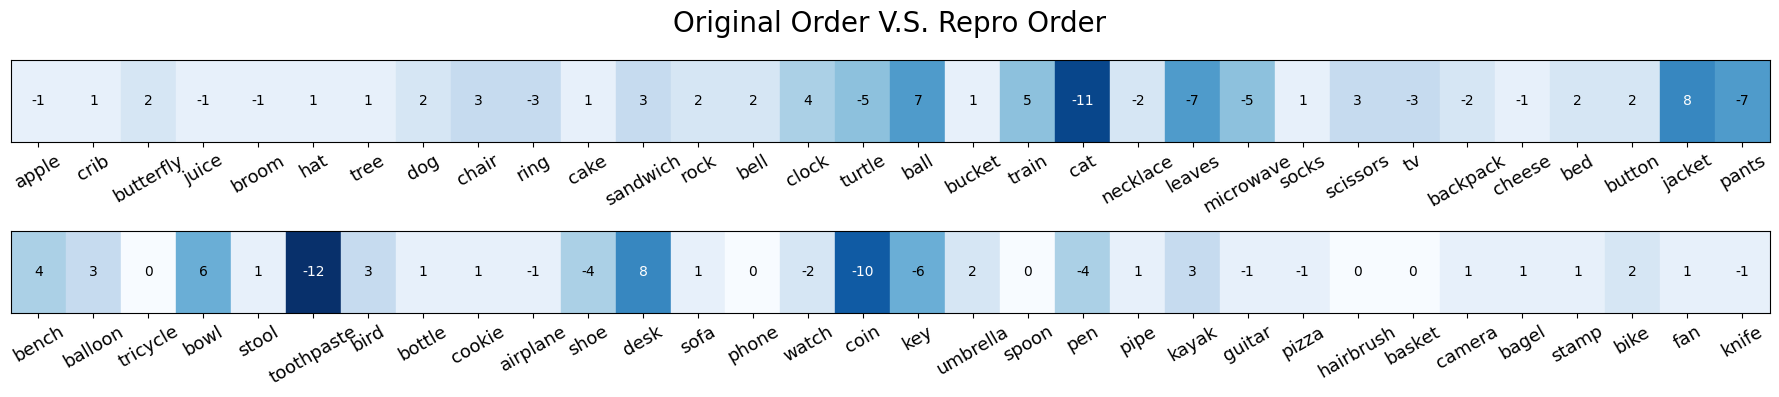

In [15]:
rank_map_reported_0 = generate_rank_map(reported_order_0)
plt_order_diff(rank_map_repro, rank_map_reported_0)

# Further Question
### What matter's most? Image resize, or trials, or tokenizer?

| Exp\Variable | Img Resize | Original Trials | Remove `<eos> <sos>` | Result Path          |
|--------------|:----------:|:------:|:---------:|----------------------|
| **Repro Previous**   |            |        |          | results/trial_0_09-01_00:40.json    |
| **Exp 1**    | ✔️         |        |           | results/trial_0_09-01_00:43.json     |
| **Exp 2**    |            | ✔️     |           | results/trial_None_09-01_00:48.json    |
| **Exp 3**    |            |        | ✔️        | results/trial_0_09-01_00:51.json   |
| **Repro Latest** | ✔️     | ✔️   | ✔️  |results/trial_0_09-01_00:33.json|


In [9]:
def process_results(file_pattern):
    files = glob.glob(file_pattern)
    if files:
        return utils.parse_results(files)
    else:
        print(f"No files matched the pattern: {file_pattern}")
        return None, None

results = {}
file_patterns = {
    'previous': 'results/trial_0_09-01_00:40.json',
    '1': 'results/trial_0_09-01_00:43.json',
    '2': 'results/trial_None_09-01_00:48.json',
    '3': 'results/trial_0_09-01_00:51.json',
    'latest': 'results/trial_0_09-01_00:33.json'
}

for label, pattern in file_patterns.items():
    df, overall_acc = process_results(pattern)
    results[label] = {
        'df': df,
        'overall_acc': overall_acc
    }

In [10]:
rank_maps = {}
taus = {}

for label, data in results.items():
    if data['df'] is not None:
        # get class order
        repro_order = data['df'].sort_values(by='Mean_Accuracy', ascending=False)['Category'].unique().tolist()
        rank_maps[label] = generate_rank_map(repro_order)
        
        # calculate Kendall's tau
        tau, p_value_tau = calculate_kendalls_tau(repro_order, reported_order)
        taus[label] = {'tau': tau, 'p_value': p_value_tau}
        print(f"Experiment {label} - Kendall's tau: {tau}, p-value: {p_value_tau}")

Experiment previous - Kendall's tau: 0.5357142857142857, p-value: 3.921718877456115e-10
Experiment 1 - Kendall's tau: 0.728174603174603, p-value: 1.8153711682340285e-17
Experiment 2 - Kendall's tau: 0.501984126984127, p-value: 4.541794940517791e-09
Experiment 3 - Kendall's tau: 0.5694444444444444, p-value: 2.9095350100935524e-11
Experiment latest - Kendall's tau: 0.751984126984127, p-value: 1.5898550177435159e-18


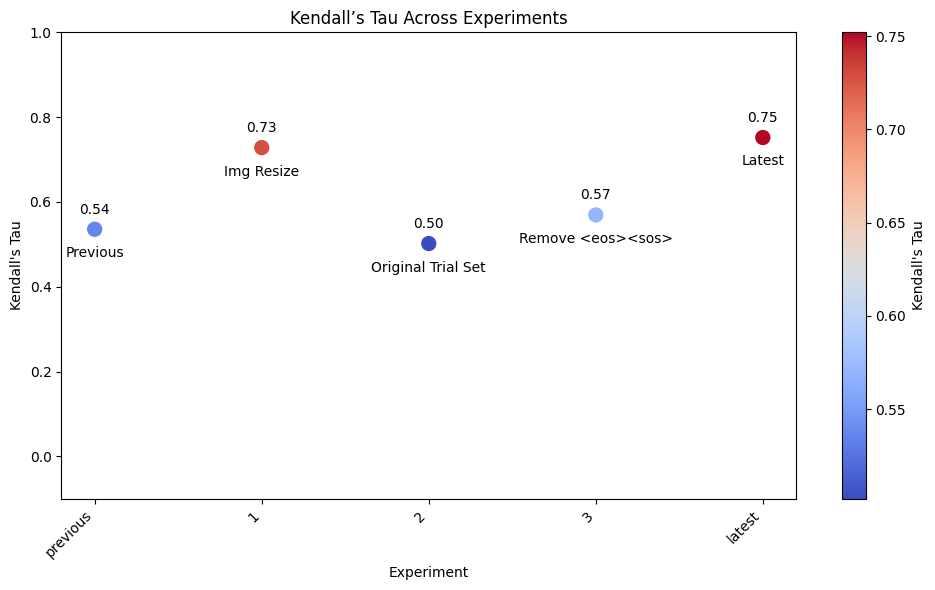

In [11]:
import matplotlib.pyplot as plt

variables = [
    "Previous",  # Repro Previous
    "Img Resize",  # Exp 1
    "Original Trial Set",  # Exp 2
    "Remove <eos><sos>",  # Exp 3
    "Latest"  # Repro Latest
]

tau_values = [taus[exp]['tau'] for exp in taus]
labels = list(taus.keys())

fig, ax = plt.subplots(figsize=(10, 6))


scatter = ax.scatter(labels, tau_values, c=tau_values, cmap='coolwarm', s=100)  # s为点的大小
cbar = plt.colorbar(scatter)
cbar.set_label("Kendall's Tau")

ax.set_xlabel('Experiment')
ax.set_ylabel("Kendall's Tau")
ax.set_title('Kendall’s Tau Across Experiments')
ax.set_ylim([-0.1, 1])  


for i, (label, tau_value) in enumerate(zip(labels, tau_values)):
    ax.text(i, tau_value + 0.03, f'{tau_value:.2f}', ha='center', va='bottom', fontsize=10)
    ax.text(i, tau_value - 0.04, variables[i], ha='center', va='top', fontsize=10)

plt.xticks(range(len(labels)), labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()

Based on above figure, seems resizing image mainly affect the order of class accuracy.

How about the overall performance? 

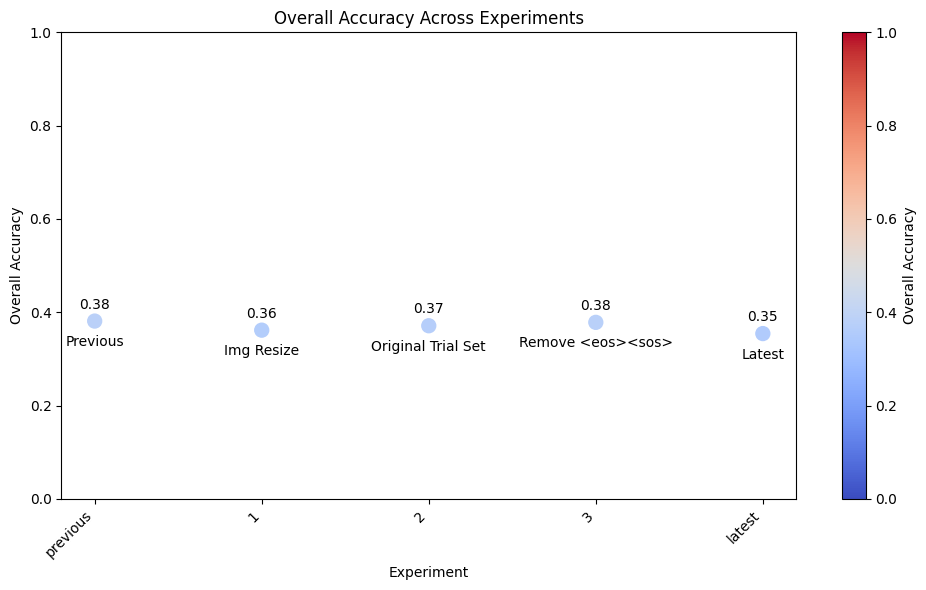

In [12]:
overall_acc_values = [results[exp]['overall_acc']['cvcl_res'] for exp in results]
labels = list(results.keys())
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(labels, overall_acc_values, c=overall_acc_values, vmax=1, vmin=0,cmap='coolwarm', s=100)
cbar = plt.colorbar(scatter)
cbar.set_label("Overall Accuracy")

ax.set_xlabel('Experiment')
ax.set_ylabel("Overall Accuracy")
ax.set_title('Overall Accuracy Across Experiments')
ax.set_ylim([0, 1])  

for i, (label, overall_acc) in enumerate(zip(labels, overall_acc_values)):
    ax.text(i, overall_acc + 0.02, f'{overall_acc:.2f}', ha='center', va='bottom', fontsize=10)
    ax.text(i, overall_acc - 0.03, variables[i], ha='center', va='top', fontsize=10)

plt.xticks(range(len(labels)), labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [13]:
# load clip results
clip_results = {}
clip_file_patterns = {
    'previous':"results/trial_0_09-01_02:05.json",
    '1': 'results/trial_0_08-31_23:04.json',
    '2': 'results/trial_None_09-01_02:07.json',
    'latest': 'results/reported_trial_repro/trial_0_08-29_17:38.json',
}

for label, pattern in clip_file_patterns.items():
    _, overall_acc = process_results(pattern)
    clip_results[label] = {
        'overall_acc': overall_acc
    }


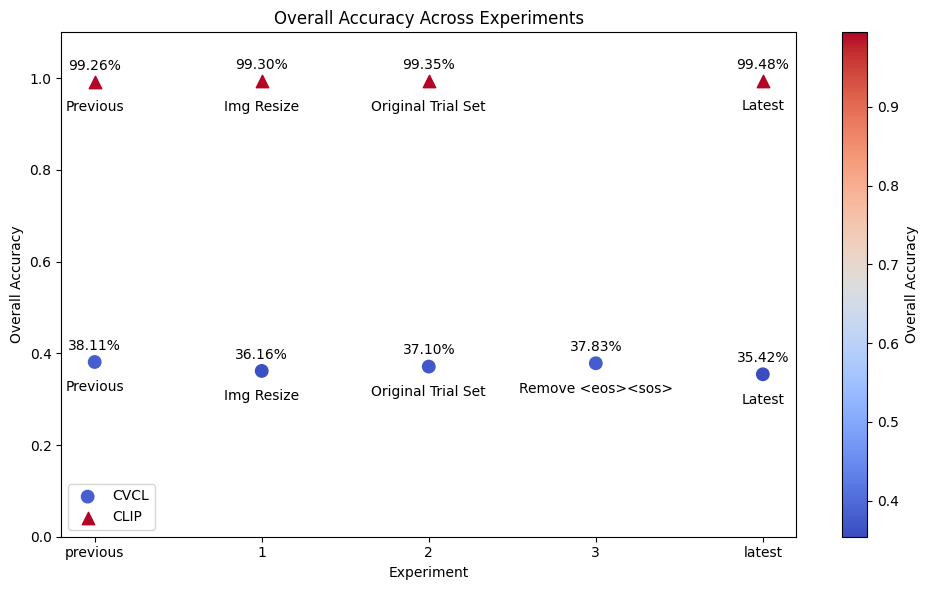

In [14]:
import matplotlib.pyplot as plt

cvcl_acc_values = [results[exp]['overall_acc']['cvcl_res'] for exp in results]
cvcl_labels = list(results.keys())
clip_acc_values = [clip_results.get(exp, {'overall_acc': {'clip': None}})['overall_acc']['clip'] for exp in cvcl_labels]  # 对齐CVCL的标签，确保对应
clip_labels = cvcl_labels  

fig, ax = plt.subplots(figsize=(10, 6))

all_acc_values = cvcl_acc_values + [x for x in clip_acc_values if x is not None]
vmin, vmax = min(all_acc_values), max(all_acc_values)

cvcl_scatter = ax.scatter(cvcl_labels, cvcl_acc_values, c=cvcl_acc_values, cmap='coolwarm', vmin=vmin, vmax=vmax, marker='o', s=80, label='CVCL')

for i, (label, acc) in enumerate(zip(clip_labels, clip_acc_values)):
    if acc is not None:  
        ax.scatter(label, acc, c=[acc], cmap='coolwarm', vmin=vmin, vmax=vmax, marker='^', s=80, label='CLIP' if i == 0 else "")
        ax.text(i, acc + 0.05, f'{acc * 100:.2f}%', ha='center', va='top', fontsize=10)
        ax.text(i, acc - 0.04, variables[i], ha='center', va='top', fontsize=10)  


cbar = plt.colorbar(cvcl_scatter)
cbar.set_label("Overall Accuracy")
plt.legend()

ax.set_xlabel('Experiment')
ax.set_ylabel("Overall Accuracy")
ax.set_title('Overall Accuracy Across Experiments')
ax.set_ylim([0, 1.1])

for i, acc in enumerate(cvcl_acc_values):
    ax.text(i, acc + 0.02, f'{acc * 100:.2f}%', ha='center', va='bottom', fontsize=10)
    ax.text(i, acc - 0.04, variables[i], ha='center', va='top', fontsize=10)  

plt.xticks(range(len(cvcl_labels)), cvcl_labels)

plt.tight_layout()
plt.show()